# Analysis of NYC Construction Activity from 2013-2023

This data analysis report focusing on the construction activities that have shaped the landscape of New York City over the past ten years. In this report, I delved into the trends, patterns, and key insights derived from a comprehensive analysis of construction permits dataset. I also explored the statistic relationship between construction activity and demographic data, and finally develop a deep learning model which can be used to predict future construction activities.

In [ ]:
#Make sure following packages are installed in your running environment 
!pip install requests pandas geopandas matplotlib census statsmodels numpy tensorflow scikit-learn mapclassify

In [2]:
import requests
import pandas as pd
import io
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 1.Data Profiling & Cleaning

In this section, I downloaded the construction permits data of new building and A1 type through api, cleaned the data by correcting column format, drop NA and filtering time between 2013-2023.I selected key features that might related to the analysis and turned the dataframe into geo dataframe by coordinate information.

In [3]:
#Request Data of NB&A1 from API
response_NB = requests.get('https://data.cityofnewyork.us/resource/ipu4-2q9a.csv?$limit=9999999&job_type=NB')
response_A1 = requests.get('https://data.cityofnewyork.us/resource/ipu4-2q9a.csv?$limit=9999999&job_type=A1')

In [4]:
#Convert to 1 combined df
df_NB = pd.read_csv(io.StringIO(response_NB.text)) 
df_A1 = pd.read_csv(io.StringIO(response_A1.text))
df = pd.concat([df_NB,df_A1], axis=0)

#View columns
df.columns

Index(['borough', 'bin__', 'house__', 'street_name', 'job__', 'job_doc___',
       'job_type', 'self_cert', 'block', 'lot', 'community_board', 'zip_code',
       'bldg_type', 'residential', 'special_district_1', 'special_district_2',
       'work_type', 'permit_status', 'filing_status', 'permit_type',
       'permit_sequence__', 'permit_subtype', 'oil_gas', 'site_fill',
       'filing_date', 'issuance_date', 'expiration_date', 'job_start_date',
       'permittee_s_first_name', 'permittee_s_last_name',
       'permittee_s_business_name', 'permittee_s_phone__',
       'permittee_s_license_type', 'permittee_s_license__',
       'act_as_superintendent', 'permittee_s_other_title', 'hic_license',
       'site_safety_mgr_s_first_name', 'site_safety_mgr_s_last_name',
       'site_safety_mgr_business_name', 'superintendent_first___last_name',
       'superintendent_business_name', 'owner_s_business_type', 'non_profit',
       'owner_s_business_name', 'owner_s_first_name', 'owner_s_last_name',
 

In the following step, as the NA generated when converting date format is only 14 rows, compared to over 280000 records overall, I decided to simply drop the NA values in job_start_date columns.

In [5]:
## Data Cleaning
#Convert date column to date format
df['job_start_date'] = pd.to_datetime(df['job_start_date'], errors='coerce')
df['dobrundate'] = pd.to_datetime(df['dobrundate'], errors='coerce')
#Correct data format
df['bldg_type'] = df['bldg_type'].astype(str)
df['gis_council_district'] = df['gis_council_district'].astype(str)
df['zip_code'] = df['zip_code'].astype(str)
df['gis_census_tract'] = df['gis_census_tract'].astype(str)
#Check NA in time stamp
na_amount = df['job_start_date'].isna().sum()
#Clean NA & error-input date
df = df.dropna(subset=['job_start_date'])
df = df[df['job_start_date']<'2023-08-26']
#Filter data of last 10 years
df = df[df['job_start_date']>'2013-01-01']
#Select key features
df = df[['borough','street_name','job_type','zip_code','bldg_type','work_type','permit_type',
         'job_start_date','owner_s_business_type', 'filing_status','non_profit','dobrundate','gis_latitude', 
         'gis_longitude', 'gis_council_district','gis_census_tract']]

print("Amount of NA in job_start_date:", na_amount)
#Convert it to geo df
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['gis_longitude'], df['gis_latitude']), crs='WGS84')
gdf

Amount of NA in job_start_date: 14


,borough,street_name,job_type,zip_code,bldg_type,work_type,permit_type,job_start_date,owner_s_business_type,filing_status,non_profit,dobrundate,gis_latitude,gis_longitude,gis_council_district,gis_census_tract,geometry
0,BROOKLYN,DOUGLASS STREET,NB,11231.0,2.0,PL,PL,2017-06-19,PARTNERSHIP,RENEWAL,N,2022-05-11,40.683034,-73.991282,33.0,69.0,POINT (-73.99128 40.68303)
1,QUEENS,BEACH 215 STREET,NB,11697.0,1.0,EQ,EQ,2019-06-06,CORPORATION,RENEWAL,N,2020-06-18,40.554860,-73.923824,32.0,91601.0,POINT (-73.92382 40.55486)
2,BROOKLYN,HERKIMER STREET,NB,11213.0,2.0,NaN,NB,2021-05-28,CORPORATION,RENEWAL,N,2022-05-11,40.678919,-73.936482,36.0,271.0,POINT (-73.93648 40.67892)
3,BRONX,EAST 241 STREET,NB,10470.0,2.0,NaN,FO,2022-05-10,CORPORATION,INITIAL,N,2022-05-11,40.903135,-73.849777,11.0,434.0,POINT (-73.84978 40.90313)
4,BRONX,EAST 241 STREET,NB,10470.0,2.0,NaN,FO,2022-05-10,CORPORATION,INITIAL,N,2022-05-11,40.903135,-73.849777,11.0,434.0,POINT (-73.84978 40.90313)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427546,BROOKLYN,19 STREET,A1,11215.0,1.0,NaN,AL,2020-09-23,INDIVIDUAL,RENEWAL,N,2023-08-26,40.661762,-73.991068,38.0,143.0,POINT (-73.99107 40.66176)
427547,STATEN ISLAND,WATERFORD COURT,A1,10305.0,1.0,PL,PL,2020-07-31,INDIVIDUAL,RENEWAL,N,2023-08-26,40.598222,-74.063650,50.0,74.0,POINT (-74.06365 40.59822)
427550,MANHATTAN,5TH AVE,A1,10001.0,2.0,NaN,AL,2018-02-23,CORPORATION,RENEWAL,N,2023-08-26,40.744821,-73.987207,4.0,76.0,POINT (-73.98721 40.74482)
427551,BROOKLYN,STRONG PLACE,A1,11231.0,1.0,NaN,AL,2023-08-25,INDIVIDUAL,INITIAL,N,2023-08-26,40.685515,-73.997692,39.0,67.0,POINT (-73.99769 40.68552)


As the numerical data column (latitude and longitude) are meaningless to show in summary table, I only included categorical type columns here.

In [6]:
#Create Summary Table for key Metrics
df_summary = df.describe(exclude = 'number')
df_summary

,borough,street_name,job_type,zip_code,bldg_type,work_type,permit_type,job_start_date,owner_s_business_type,filing_status,non_profit,dobrundate,gis_council_district,gis_census_tract
count,285630,285630,285630,285630,285630,100282,285630,285630,285188,285630,285204,285630,285630,285630
unique,5,9378,2,209,2,3,6,2814,14,2,2,1249,52,1298
top,BROOKLYN,BROADWAY,NB,11221.0,2.0,PL,AL,2015-06-12 00:00:00,INDIVIDUAL,RENEWAL,N,2022-05-09 00:00:00,33.0,91601.0
freq,107787,2317,157101,6597,155658,61453,66861,875,118619,158269,272544,263454,13943,3668
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-02 00:00:00,NaN,NaN,NaN,2017-11-03 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-25 00:00:00,NaN,NaN,NaN,2023-08-27 00:00:00,NaN,NaN


## 2.Data Exlporation & Visualization

### 2.1 Distribution Analysis
In this section, I explored the constuction activity distribution among values of different features inlcuding borough, job type, owner's business type and filing status.  

In [7]:
## Distribution plot
#Function for drawing distribution plot
def plot_distribution(df, column, plt_name):
    #aggregation by the feature
    distribution = df.groupby(column).size().reset_index(name='count')
    distribution = distribution.sort_values(by= 'count', ascending=False)
    #draw histogram
    plt.figure(figsize=(6, 4))
    
    plt.bar(distribution[column], distribution['count'])
    plt.xlabel(plt_name)
    plt.xticks(rotation=45, fontsize=8)    
    plt.ylabel('Frequency')
    plt.title('Construction Activity Distribution of '+column)
    plt.tight_layout()  
    plt.show()

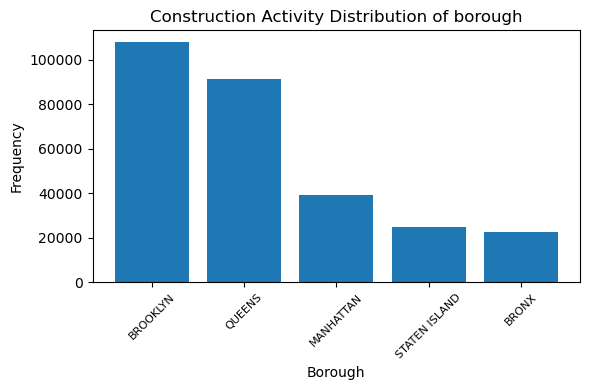

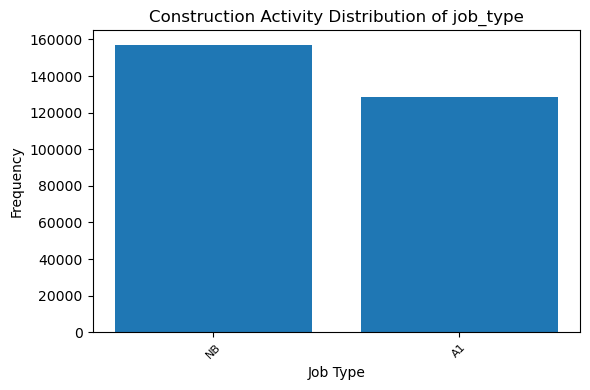

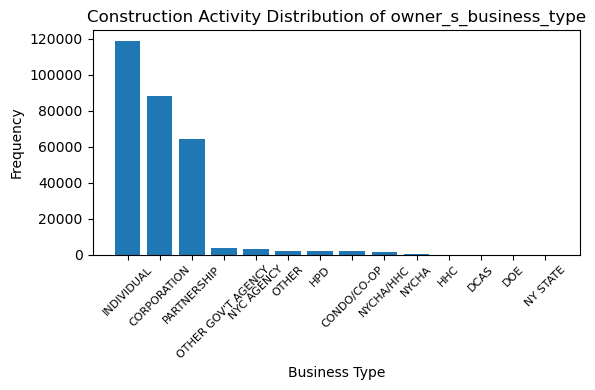

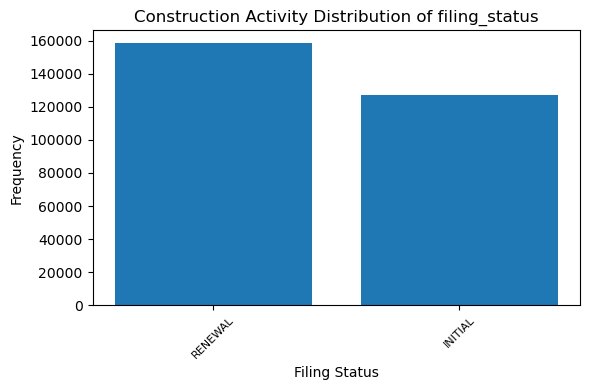

In [8]:
#Show distribution
plot_distribution(df, 'borough', 'Borough')
plot_distribution(df, 'job_type', 'Job Type')
plot_distribution(df, 'owner_s_business_type', 'Business Type')
plot_distribution(df, 'filing_status', 'Filing Status')

### 2.2 Construction Activity Spatial Density
In this section, I explored the spatial distribution of construction activity over last 10 years. As the area of each zip varies a lot, I used activity count divided by area as spatial density. The south end of Manhattan and west end of Brooklyn areas tend to have higher density.

In [30]:
import mapclassify

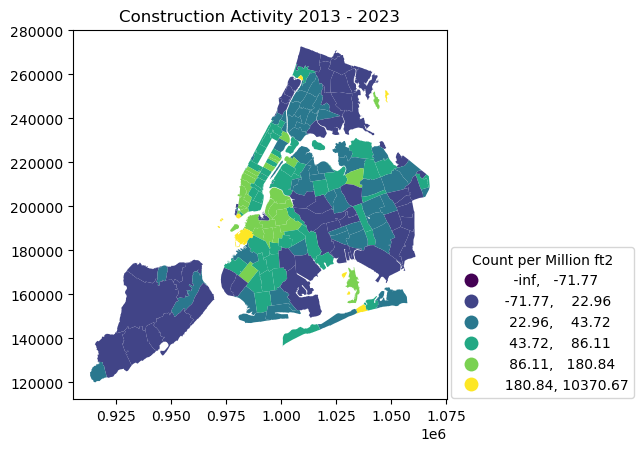

In [74]:
## Visualization by area
#Read zip area shape file
zip = gpd.read_file('Data/ZIP_CODE_040114.shp')
#join df by zip code
df['zip_code'] = df['zip_code'].astype(float)
zip['ZIPCODE'] = zip['ZIPCODE'].astype(float)
zip_join = zip.merge(df, left_on=['ZIPCODE'], right_on=['zip_code'], how='right')
#Aggregation by zip code
zip_count = zip_join.groupby('ZIPCODE').size().reset_index(name='count')
zip_gdf = zip.merge(zip_count, on=['ZIPCODE'])[['ZIPCODE','geometry','count','AREA']]
zip_gdf['intense_by_area'] = zip_gdf['count']/zip_gdf['AREA']*1000000

#Mapping the construction activity by zip code
ax = zip_gdf.plot(column='intense_by_area', cmap='viridis', scheme='BoxPlot', legend=True)
ax.set_title("Construction Activity 2013 - 2023")
legend=ax.get_legend()
legend.set_bbox_to_anchor((1.52, 0.43))
legend.set_title("Count per Million ft2")

plt.show()

### 2.3 Daily Construction Intensity
In this section, daily activity counts of last 10 years were engineered and ploted. As the actual construction activity is the key metrics here, I used 'job_start_date' column as date label.
The construction intensity reached its peak around 2015-2016 and has been decreasing overall since then.

In [76]:
## Daily construction data
#Aggregation by date
daily_cons = df.groupby('job_start_date').size().reset_index(name='activity_count')
daily_cons.set_index('job_start_date', inplace=True)
#Summary table of Daily construction
summary_cons = daily_cons.describe()
summary_cons

,activity_count
count,2814.000000
mean,101.503198
std,70.542939
min,1.000000
25%,42.250000
50%,106.000000
75%,146.000000
max,875.000000


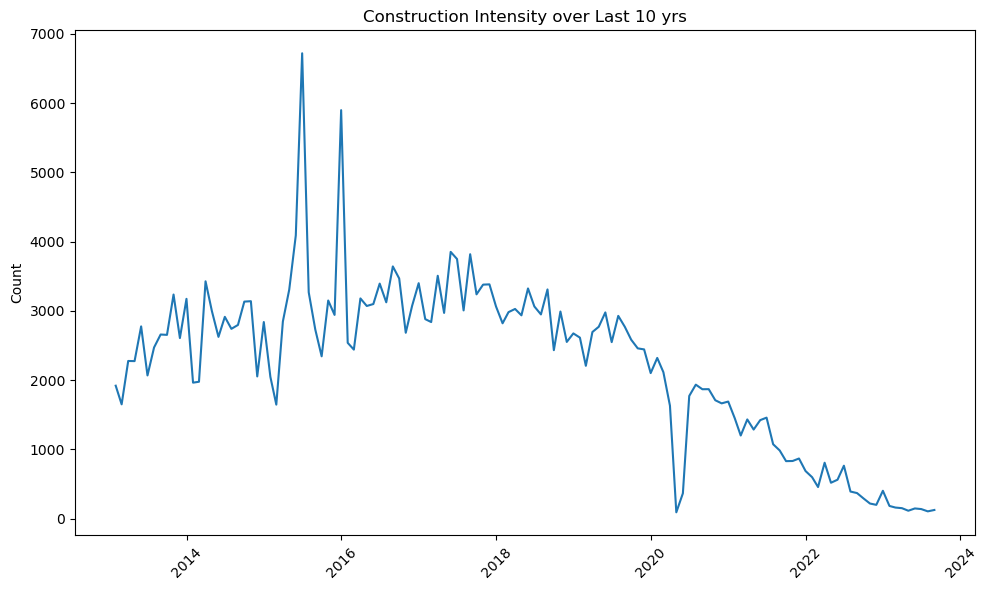

In [77]:
## Create a time series plot
#Aggregation by month
monthly_cons = daily_cons.resample('M').sum()

#create figure
plt.figure(figsize=(10, 6))
plt.plot(monthly_cons.index, monthly_cons['activity_count'], linestyle='-')
#labels and title
plt.ylabel('Count')
plt.title('Construction Intensity over Last 10 yrs')
plt.xticks(rotation=45)  
plt.tight_layout()       
plt.show()

## 3.Spatial Join with Census Data

The main data points was spatially joined with census block with demographic features of total population and median household income. I concluded both numeric and categorical columns each with a summary table. The final data was saved in 'Output_data' folder. 

In [78]:
from census import Census

In [79]:
## Query Census data
#set api
c = Census("349e9f6b8333d8897ab8b7349768c71ab58f1dc8")
#query function
def get_census(variables, state, county):
    ch_census = c.acs5.state_county_tract(fields = variables,
                                      state_fips = state,
                                      county_fips = county,
                                      tract = "*",
                                      year = 2020)
    ch_df = pd.DataFrame(ch_census)
    return ch_df
#input variable
variables = ['NAME', 'B01003_001E', 'B19013_001E']
nyc_county_fips = ['005', '047', '061', '081', '085']
ny_fips = '36'
census = pd.DataFrame()
#loop query for counties in NYC
for county in nyc_county_fips:
    ch = get_census(variables, ny_fips, county)
    census =  pd.concat([census,ch])
census

,NAME,B01003_001E,B19013_001E,state,county,tract
0,"Census Tract 199, Bronx County, New York",7937.0,33267.0,36,005,019900
1,"Census Tract 200, Bronx County, New York",4750.0,40847.0,36,005,020000
2,"Census Tract 201, Bronx County, New York",3887.0,42464.0,36,005,020100
3,"Census Tract 202, Bronx County, New York",2387.0,41393.0,36,005,020200
4,"Census Tract 204, Bronx County, New York",3279.0,60278.0,36,005,020400
...,...,...,...,...,...,...
121,"Census Tract 132.04, Richmond County, New York",4809.0,90625.0,36,085,013204
122,"Census Tract 133.01, Richmond County, New York",1067.0,11343.0,36,085,013301
123,"Census Tract 133.02, Richmond County, New York",3320.0,68487.0,36,085,013302
124,"Census Tract 134, Richmond County, New York",4127.0,86875.0,36,085,013400


In [93]:
#Rename columns & add geoid
census = census.rename(columns={'B01003_001E': 'Total_Pop', 'B19013_001E': 'Median_HH_Income'})
census['geoid'] = census['state']+census['county']+census['tract']
#Import Census Tract Geometry
tracts = gpd.read_file('Data/geo_export.shp')[['ntaname','geoid','cdtaname','shape_leng','shape_area','geometry' ]]
census_tracts = tracts.merge(census, on='geoid')
census_tracts

,ntaname,geoid,cdtaname,shape_leng,shape_area,geometry,NAME,Total_Pop,Median_HH_Income,state,county,tract
0,The Battery-Governors Island-Ellis Island-Libe...,36061000100,MN01 Financial District-Tribeca (CD 1 Equivalent),10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...","Census Tract 1, New York County, New York",0.0,-666666666.0,36,061,000100
1,Chinatown-Two Bridges,36061000201,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4754.495247,9.723121e+05,"POLYGON ((-73.98450 40.70951, -73.98655 40.709...","Census Tract 2.01, New York County, New York",2761.0,30435.0,36,061,000201
2,Chinatown-Two Bridges,36061000600,MN03 Lower East Side-Chinatown (CD 3 Equivalent),6976.286215,2.582705e+06,"POLYGON ((-73.99022 40.71440, -73.98934 40.714...","Census Tract 6, New York County, New York",10628.0,17398.0,36,061,000600
3,Lower East Side,36061001401,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5075.332000,1.006117e+06,"POLYGON ((-73.98837 40.71645, -73.98754 40.716...","Census Tract 14.01, New York County, New York",2999.0,97875.0,36,061,001401
4,Lower East Side,36061001402,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4459.156019,1.226206e+06,"POLYGON ((-73.98507 40.71908, -73.98423 40.718...","Census Tract 14.02, New York County, New York",2693.0,35064.0,36,061,001402
...,...,...,...,...,...,...,...,...,...,...,...,...
2320,Marine Park-Plumb Island,36047066600,BK18 Canarsie-Flatlands (CD 18 Approximation),96948.219292,4.327690e+07,"MULTIPOLYGON (((-73.91513 40.58627, -73.91510 ...","Census Tract 666, Kings County, New York",0.0,-666666666.0,36,047,066600
2321,East Village,36061002400,MN03 Lower East Side-Chinatown (CD 3 Equivalent),9497.307624,1.863567e+06,"MULTIPOLYGON (((-73.96715 40.71832, -73.96656 ...","Census Tract 24, New York County, New York",4171.0,12917.0,36,061,002400
2322,Williamsburg,36047055500,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),7293.581985,2.830412e+06,"POLYGON ((-73.95901 40.71864, -73.95961 40.718...","Census Tract 555, Kings County, New York",8541.0,166622.0,36,047,055500
2323,Prospect Park,36047017700,BK55 Prospect Park (JIA 55 Approximation),24199.068858,2.732422e+07,"POLYGON ((-73.96748 40.67286, -73.96713 40.672...","Census Tract 177, Kings County, New York",0.0,-666666666.0,36,047,017700


In [81]:
## Perform Spatial Join
gdf = gdf.to_crs(census_tracts.crs)
final_gdf = gpd.sjoin(gdf, census_tracts, how='left')
final_gdf

,borough,street_name,job_type,zip_code,bldg_type,work_type,permit_type,job_start_date,owner_s_business_type,filing_status,...,geoid,cdtaname,shape_leng,shape_area,NAME,Total_Pop,Median_HH_Income,state,county,tract
0,BROOKLYN,DOUGLASS STREET,NB,11231.0,2.0,PL,PL,2017-06-19,PARTNERSHIP,RENEWAL,...,36047006902,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,4451.326062,1.126490e+06,"Census Tract 69.02, Kings County, New York",2182.0,166033.0,36,047,006902
1,QUEENS,BEACH 215 STREET,NB,11697.0,1.0,EQ,EQ,2019-06-06,CORPORATION,RENEWAL,...,36081091603,QN14 The Rockaways (CD 14 Approximation),38107.118820,2.016795e+07,"Census Tract 916.03, Queens County, New York",3527.0,116205.0,36,081,091603
2,BROOKLYN,HERKIMER STREET,NB,11213.0,2.0,NaN,NB,2021-05-28,CORPORATION,RENEWAL,...,36047027100,BK03 Bedford-Stuyvesant (CD 3 Approximation),9428.077249,2.660205e+06,"Census Tract 271, Kings County, New York",3351.0,78125.0,36,047,027100
3,BRONX,EAST 241 STREET,NB,10470.0,2.0,NaN,FO,2022-05-10,CORPORATION,INITIAL,...,36005043400,BX12 Wakefield-Williamsbridge-Eastchester (CD ...,10436.350772,3.761013e+06,"Census Tract 434, Bronx County, New York",3796.0,72917.0,36,005,043400
4,BRONX,EAST 241 STREET,NB,10470.0,2.0,NaN,FO,2022-05-10,CORPORATION,INITIAL,...,36005043400,BX12 Wakefield-Williamsbridge-Eastchester (CD ...,10436.350772,3.761013e+06,"Census Tract 434, Bronx County, New York",3796.0,72917.0,36,005,043400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427546,BROOKLYN,19 STREET,A1,11215.0,1.0,NaN,AL,2020-09-23,INDIVIDUAL,RENEWAL,...,36047014300,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,6688.231694,2.335437e+06,"Census Tract 143, Kings County, New York",3599.0,115444.0,36,047,014300
427547,STATEN ISLAND,WATERFORD COURT,A1,10305.0,1.0,PL,PL,2020-07-31,INDIVIDUAL,RENEWAL,...,36085007400,SI02 Mid-Island (CD 2 Approximation),9902.949173,5.788238e+06,"Census Tract 74, Richmond County, New York",4494.0,65804.0,36,085,007400
427550,MANHATTAN,5TH AVE,A1,10001.0,2.0,NaN,AL,2018-02-23,CORPORATION,RENEWAL,...,36061007600,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,5717.633437,1.873518e+06,"Census Tract 76, New York County, New York",2115.0,102266.0,36,061,007600
427551,BROOKLYN,STRONG PLACE,A1,11231.0,1.0,NaN,AL,2023-08-25,INDIVIDUAL,INITIAL,...,36047006700,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,5236.047803,1.680804e+06,"Census Tract 67, Kings County, New York",3980.0,161453.0,36,047,006700


In [82]:
## Generate Summary Table for final_gdf
#Summary Table for categorical data
category_summary = final_gdf.describe(exclude = 'number')
category_summary

,borough,street_name,job_type,zip_code,bldg_type,work_type,permit_type,job_start_date,owner_s_business_type,filing_status,...,gis_council_district,gis_census_tract,geometry,ntaname,geoid,cdtaname,NAME,state,county,tract
count,285630,285630,285630,285630,285630,100282,285630,285630,285188,285630,...,285630,285630,285630,283844,283844,283844,283844,283844,283844,283844
unique,5,9378,2,209,2,3,6,2814,14,2,...,52,1298,43837,228,2227,67,2227,1,5,1471
top,BROOKLYN,BROADWAY,NB,11221.0,2.0,PL,AL,2015-06-12 00:00:00,INDIVIDUAL,RENEWAL,...,33.0,91601.0,POINT EMPTY,Bedford-Stuyvesant (West),36081091603,QN07 Flushing-Murray Hill-Whitestone (CD 7 App...,"Census Tract 916.03, Queens County, New York",36,047,091603
freq,107787,2317,157101,6597,155658,61453,66861,875,118619,158269,...,13943,3668,1786,6973,3668,15827,3668,283844,107349,3668
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-02 00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-25 00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
#Summary Table for numerical data
numerical_summary = final_gdf[['Total_Pop','Median_HH_Income','shape_area','shape_leng']].describe()
numerical_summary

,Total_Pop,Median_HH_Income,shape_area,shape_leng
count,283844.000000,2.838440e+05,2.838440e+05,283844.000000
mean,4002.170802,-8.162903e+06,4.976815e+06,9950.377657
std,1863.098221,7.369489e+07,8.233828e+06,7800.309042
min,0.000000,-6.666667e+08,4.005503e+05,2569.477865
25%,2663.000000,5.388900e+04,1.786238e+06,5717.633437
50%,3697.000000,7.847400e+04,2.226124e+06,7000.165255
75%,5033.000000,1.038100e+05,5.054383e+06,11332.696485
max,16600.000000,2.500010e+05,1.971899e+08,103582.252890


In [ ]:
## Export as shapefile & excel
#Change date to str as Shapefile doesn't support date format
final_gdf['job_start_date'] = final_gdf['job_start_date'].astype(str)
final_gdf['dobrundate'] = final_gdf['dobrundate'].astype(str)

final_gdf.to_file('Output_data/final_data.shp')
final_gdf.to_excel('Output_data/final_data.xlsx', index=False)

## 4.Census Data Statistic Analysis

In this section, a linear regression was performed to detect the correlation between total population & median household income and construction activity density.

In [84]:
import statsmodels.api as sm

In [96]:
#Aggregation by census tracts
cons_tracts = final_gdf.groupby('geoid').size().reset_index(name='activity_count')
#Rejoin demographic data
cons_census = cons_tracts.merge(census_tracts, on='geoid')
#Cauculate activity density
cons_census['density'] = cons_census['activity_count']/cons_census['shape_area'] * 1000000
cons_census

,geoid,activity_count,ntaname,cdtaname,shape_leng,shape_area,geometry,NAME,Total_Pop,Median_HH_Income,state,county,tract,density
0,36005000200,74,Soundview-Clason Point,BX09 Soundview-Parkchester (CD 9 Approximation),15251.735414,4.877013e+06,"POLYGON ((-73.85652 40.80524, -73.85652 40.805...","Census Tract 2, Bronx County, New York",4167.0,68000.0,36,005,000200,15.173223
1,36005000400,389,Soundview-Clason Point,BX09 Soundview-Parkchester (CD 9 Approximation),24785.525725,8.557953e+06,"POLYGON ((-73.84611 40.81310, -73.84647 40.812...","Census Tract 4, Bronx County, New York",5684.0,93155.0,36,005,000400,45.454796
2,36005001600,41,Soundview-Clason Point,BX09 Soundview-Parkchester (CD 9 Approximation),9671.306267,5.221330e+06,"POLYGON ((-73.85514 40.82244, -73.85497 40.821...","Census Tract 16, Bronx County, New York",5917.0,34766.0,36,005,001600,7.852405
3,36005001901,176,Mott Haven-Port Morris,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,6151.012561,2.232574e+06,"POLYGON ((-73.92428 40.80719, -73.92429 40.807...","Census Tract 19.01, Bronx County, New York",1910.0,61711.0,36,005,001901,78.832787
4,36005001902,177,Mott Haven-Port Morris,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,14105.209225,5.059222e+06,"POLYGON ((-73.91882 40.80491, -73.91787 40.804...","Census Tract 19.02, Bronx County, New York",1334.0,53882.0,36,005,001902,34.985614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222,36085030301,19,Mariner's Harbor-Arlington-Graniteville,SI01 North Shore (CD 1 Equivalent),18471.952663,7.766660e+06,"POLYGON ((-74.14611 40.62493, -74.14618 40.624...","Census Tract 303.01, Richmond County, New York",5151.0,89777.0,36,085,030301,2.446354
2223,36085030302,126,Mariner's Harbor-Arlington-Graniteville,SI01 North Shore (CD 1 Equivalent),13923.141306,9.788181e+06,"POLYGON ((-74.16050 40.62653, -74.16024 40.626...","Census Tract 303.02, Richmond County, New York",6569.0,90979.0,36,085,030302,12.872668
2224,36085031901,61,Mariner's Harbor-Arlington-Graniteville,SI01 North Shore (CD 1 Equivalent),8255.026915,4.126596e+06,"POLYGON ((-74.16050 40.62653, -74.16118 40.626...","Census Tract 319.01, Richmond County, New York",3293.0,40313.0,36,085,031901,14.782160
2225,36085031902,196,Mariner's Harbor-Arlington-Graniteville,SI01 North Shore (CD 1 Equivalent),18067.518620,7.019455e+06,"POLYGON ((-74.16022 40.63834, -74.16015 40.638...","Census Tract 319.02, Richmond County, New York",4953.0,71000.0,36,085,031902,27.922396


In [102]:
## Run Linear Regression
regression_data = cons_census[cons_census['Total_Pop']>0]
X = sm.add_constant(regression_data[['Total_Pop', 'Median_HH_Income']])
y = regression_data['density']

# Initialize linear model
model = sm.OLS(y, X).fit()
# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                density   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.332
Date:                Mon, 28 Aug 2023   Prob (F-statistic):             0.0359
Time:                        16:00:59   Log-Likelihood:                -11966.
No. Observations:                2187   AIC:                         2.394e+04
Df Residuals:                    2184   BIC:                         2.396e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               53.0501      2.734  

From the model result, we can say that total population is slightly positively correlated with construction activity density in p<0.5 level. 
Median Household income has no correlation with construction activity density. 

## 5.Construction Activity Prediction Using LSTM Deep Learning Model

LSTM (Long Short-Term Memory) is a type of recurrent neural network designed for processing and predicting sequences, capable of learning long-range dependencies. In this section, I used trained a LSTM model to predict the future construction activity. 

In [104]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

In [105]:
#Normalize the data
scaler = StandardScaler()
daily_cons_lstm = daily_cons.copy()
daily_cons_lstm['activity_count'] = scaler.fit_transform(daily_cons_lstm['activity_count'].values.reshape(-1, 1))

In [106]:
#Prepare the data for training
sequence_length = 15 
X = []
y = []
for i in range(len(daily_cons_lstm) - sequence_length):
    X.append(daily_cons_lstm['activity_count'][i:i + sequence_length])
    y.append(daily_cons_lstm['activity_count'][i + sequence_length])
X = np.array(X)
y = np.array(y)

In [107]:
#Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
#Reshape the data to fit the LSTM input shape (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [108]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(sequence_length,1)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [109]:
#Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
140/140 [==============================] - 4s 7ms/step - loss: 0.6417
Epoch 2/50
140/140 [==============================] - 1s 7ms/step - loss: 0.6089
Epoch 3/50
140/140 [==============================] - 1s 6ms/step - loss: 0.6049
Epoch 4/50
140/140 [==============================] - 1s 6ms/step - loss: 0.5999
Epoch 5/50
140/140 [==============================] - 1s 6ms/step - loss: 0.5895
Epoch 6/50
140/140 [==============================] - 1s 6ms/step - loss: 0.5916
Epoch 7/50
140/140 [==============================] - 1s 6ms/step - loss: 0.5851
Epoch 8/50
140/140 [==============================] - 1s 6ms/step - loss: 0.5848
Epoch 9/50
140/140 [==============================] - 1s 7ms/step - loss: 0.5777
Epoch 10/50
140/140 [==============================] - 1s 7ms/step - loss: 0.5814
Epoch 11/50
140/140 [==============================] - 1s 7ms/step - loss: 0.5652
Epoch 12/50
140/140 [==============================] - 1s 8ms/step - loss: 0.5791
Epoch 13/50
140/140 [====

18/18 [==============================] - 0s 3ms/step


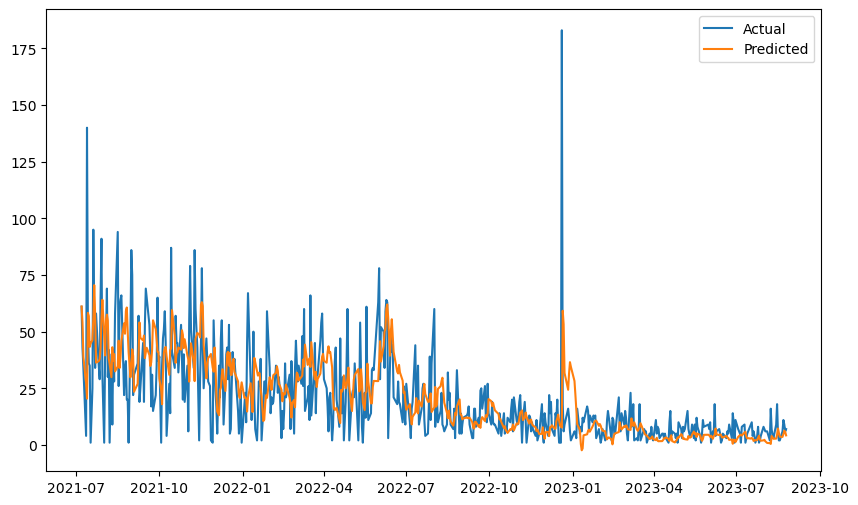

In [114]:
#Predict on the test data
predictions = model.predict(X_test)

#Inverse transform the predictions to original scale
predictions = scaler.inverse_transform(predictions)

#Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(daily_cons.index[train_size + sequence_length:], daily_cons['activity_count'].values[train_size + sequence_length:], label='Actual')
plt.plot(daily_cons.index[train_size + sequence_length:], predictions, label='Predicted')
plt.legend()
plt.show()

From the plot above, we can say that though the model cannot accurately predict the construction activity daily, it is capable of capturing the overall trend.